# **Đường dẫn folder chứa data**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
folder = "/content/gdrive/MyDrive/Năm 3/04. Machine Learning"

Mounted at /content/gdrive


# **1. Libraries**

In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.impute import KNNImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

from yellowbrick.cluster import SilhouetteVisualizer
#
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# **2. Reading Dataset**

In [ ]:
df = pd.read_csv(folder + "/Customer_Data.csv")
df.head().style.background_gradient(cmap="YlOrBr")

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,C10001,40.900749,0.818182,95.400000,0.000000,95.400000,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.000000,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.000000,0.000000,0.000000,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.000000,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.170000,773.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.000000,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.000000,1499.000000,0.000000,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.000000,0.000000,nan,0.000000,12
4,C10005,817.714335,1.000000,16.000000,16.000000,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.000000,678.334763,244.791237,0.000000,12


In [ ]:
df.tail().style.background_gradient(cmap="YlOrBr")

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
8945,C19186,28.493517,1.000000,291.120000,0.000000,291.120000,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.000000,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.000000,0.000000,300.000000,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.000000,275.861322,nan,0.000000,6
8947,C19188,23.398673,0.833333,144.400000,0.000000,144.400000,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.000000,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.000000,0.000000,0.000000,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.000000,52.549959,55.755628,0.250000,6
8949,C19190,372.708075,0.666667,1093.250000,1093.250000,0.000000,127.040008,0.666667,0.666667,0.000000,0.333333,2,23,1200.000000,63.165404,88.288956,0.000000,6


# **3. Kiểm tra sơ bộ**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cust_id                           8950 non-null   object 
 1   balance                           8950 non-null   float64
 2   balance_frequency                 8950 non-null   float64
 3   purchases                         8950 non-null   float64
 4   oneoff_purchases                  8950 non-null   float64
 5   installments_purchases            8950 non-null   float64
 6   cash_advance                      8950 non-null   float64
 7   purchases_frequency               8950 non-null   float64
 8   oneoff_purchases_frequency        8950 non-null   float64
 9   purchases_installments_frequency  8950 non-null   float64
 10  cash_advance_frequency            8950 non-null   float64
 11  cash_advance_trx                  8950 non-null   int64  
 12  purcha

> Từ kết quả trên có thể thấy:
- Bộ dữ liệu có 8950 dòng (mỗi dòng là một khách hàng) và 18 cột (18 đặc trưng)
- 2 cột *credit_limit* và *minimum_payments* có giá trị bị thiếu
>- Chỉ có cột *cust_id* có kiểu dữ liệu là object, tất cả các cột còn lại đều có kiểu dữ liệu là số (float64 và int64)


> **Như vậy, có thể bỏ cột cust_id vì cột này không có giá trị trong bài toán này**

In [ ]:
df.drop("cust_id", axis=1, inplace=True)

In [ ]:
print(f"Số cột còn lại: {len(df.columns.to_list())}")

Số cột còn lại: 17


> **17 cột còn lại đều có kiểu dữ liệu là số**

> **Nhận diện các giá trị bị thiếu: đếm và tính phần trăm**

In [ ]:
is_nan = df.isna().sum().to_frame(name='Number_of_NaN')
is_nan.insert(1,'Percent(%)', [round(x/df.shape[0]*100,2) for x in is_nan.Number_of_NaN])
is_nan

,Number_of_NaN,Percent(%)
balance,0,0.00
balance_frequency,0,0.00
purchases,0,0.00
oneoff_purchases,0,0.00
installments_purchases,0,0.00
cash_advance,0,0.00
purchases_frequency,0,0.00
oneoff_purchases_frequency,0,0.00
purchases_installments_frequency,0,0.00
cash_advance_frequency,0,0.00


> Cột ***credit_limit*** có 1 giá trị bị thiếu (0.01%)
>
> Cột ***minimum_payments*** có 313 giá trị bị thiếu (3.5%)

> **Nhận diện các giá trị 0**

In [ ]:
is_zero = (df == 0).sum().to_frame(name='Number_of_Zeros')
is_zero.insert(1,'Percent(%)', [round(x/df.shape[0]*100,2) for x in is_zero.Number_of_Zeros])
is_zero

,Number_of_Zeros,Percent(%)
balance,80,0.89
balance_frequency,80,0.89
purchases,2044,22.84
oneoff_purchases,4302,48.07
installments_purchases,3916,43.75
cash_advance,4628,51.71
purchases_frequency,2043,22.83
oneoff_purchases_frequency,4302,48.07
purchases_installments_frequency,3915,43.74
cash_advance_frequency,4628,51.71


> Nhiều cột có số giá trị 0 chiếm trên 50%

# **4. Exploratory Data Analysis (EDA)**

## **4.1 Univariate Analysis**
Phân tích 1 biến, bao gôm:
- Thống kê mô tả (tính các đại lượng: count, mean, median, mode, range, std, min,
- Trực quan hóa dữ liệu

In [ ]:
# Thống kê mô tả, thêm các giá trị: median, mode, range
df_describe = df.describe().T
df_describe.insert(2, "median", df.median())
df_describe.insert(3, "mode", df.mode().iloc[0])
df_describe.insert(4, "range", df.max() - df.min())
df_describe

,count,mean,median,mode,range,std,min,25%,50%,75%,max
balance,8950.0,1564.474828,873.385231,0.000000,19043.138560,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
balance_frequency,8950.0,0.877271,1.000000,1.000000,1.000000,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
purchases,8950.0,1003.204834,361.280000,0.000000,49039.570000,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
oneoff_purchases,8950.0,592.437371,38.000000,0.000000,40761.250000,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
installments_purchases,8950.0,411.067645,89.000000,0.000000,22500.000000,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
cash_advance,8950.0,978.871112,0.000000,0.000000,47137.211760,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
purchases_frequency,8950.0,0.490351,0.500000,1.000000,1.000000,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
oneoff_purchases_frequency,8950.0,0.202458,0.083333,0.000000,1.000000,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
purchases_installments_frequency,8950.0,0.364437,0.166667,0.000000,1.000000,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
cash_advance_frequency,8950.0,0.135144,0.000000,0.000000,1.500000,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


> Vì cả 17 cột hiện giờ chỉ có kiểu giá trị số, vẽ biểu đồ histogram để xem phân phối của các cột

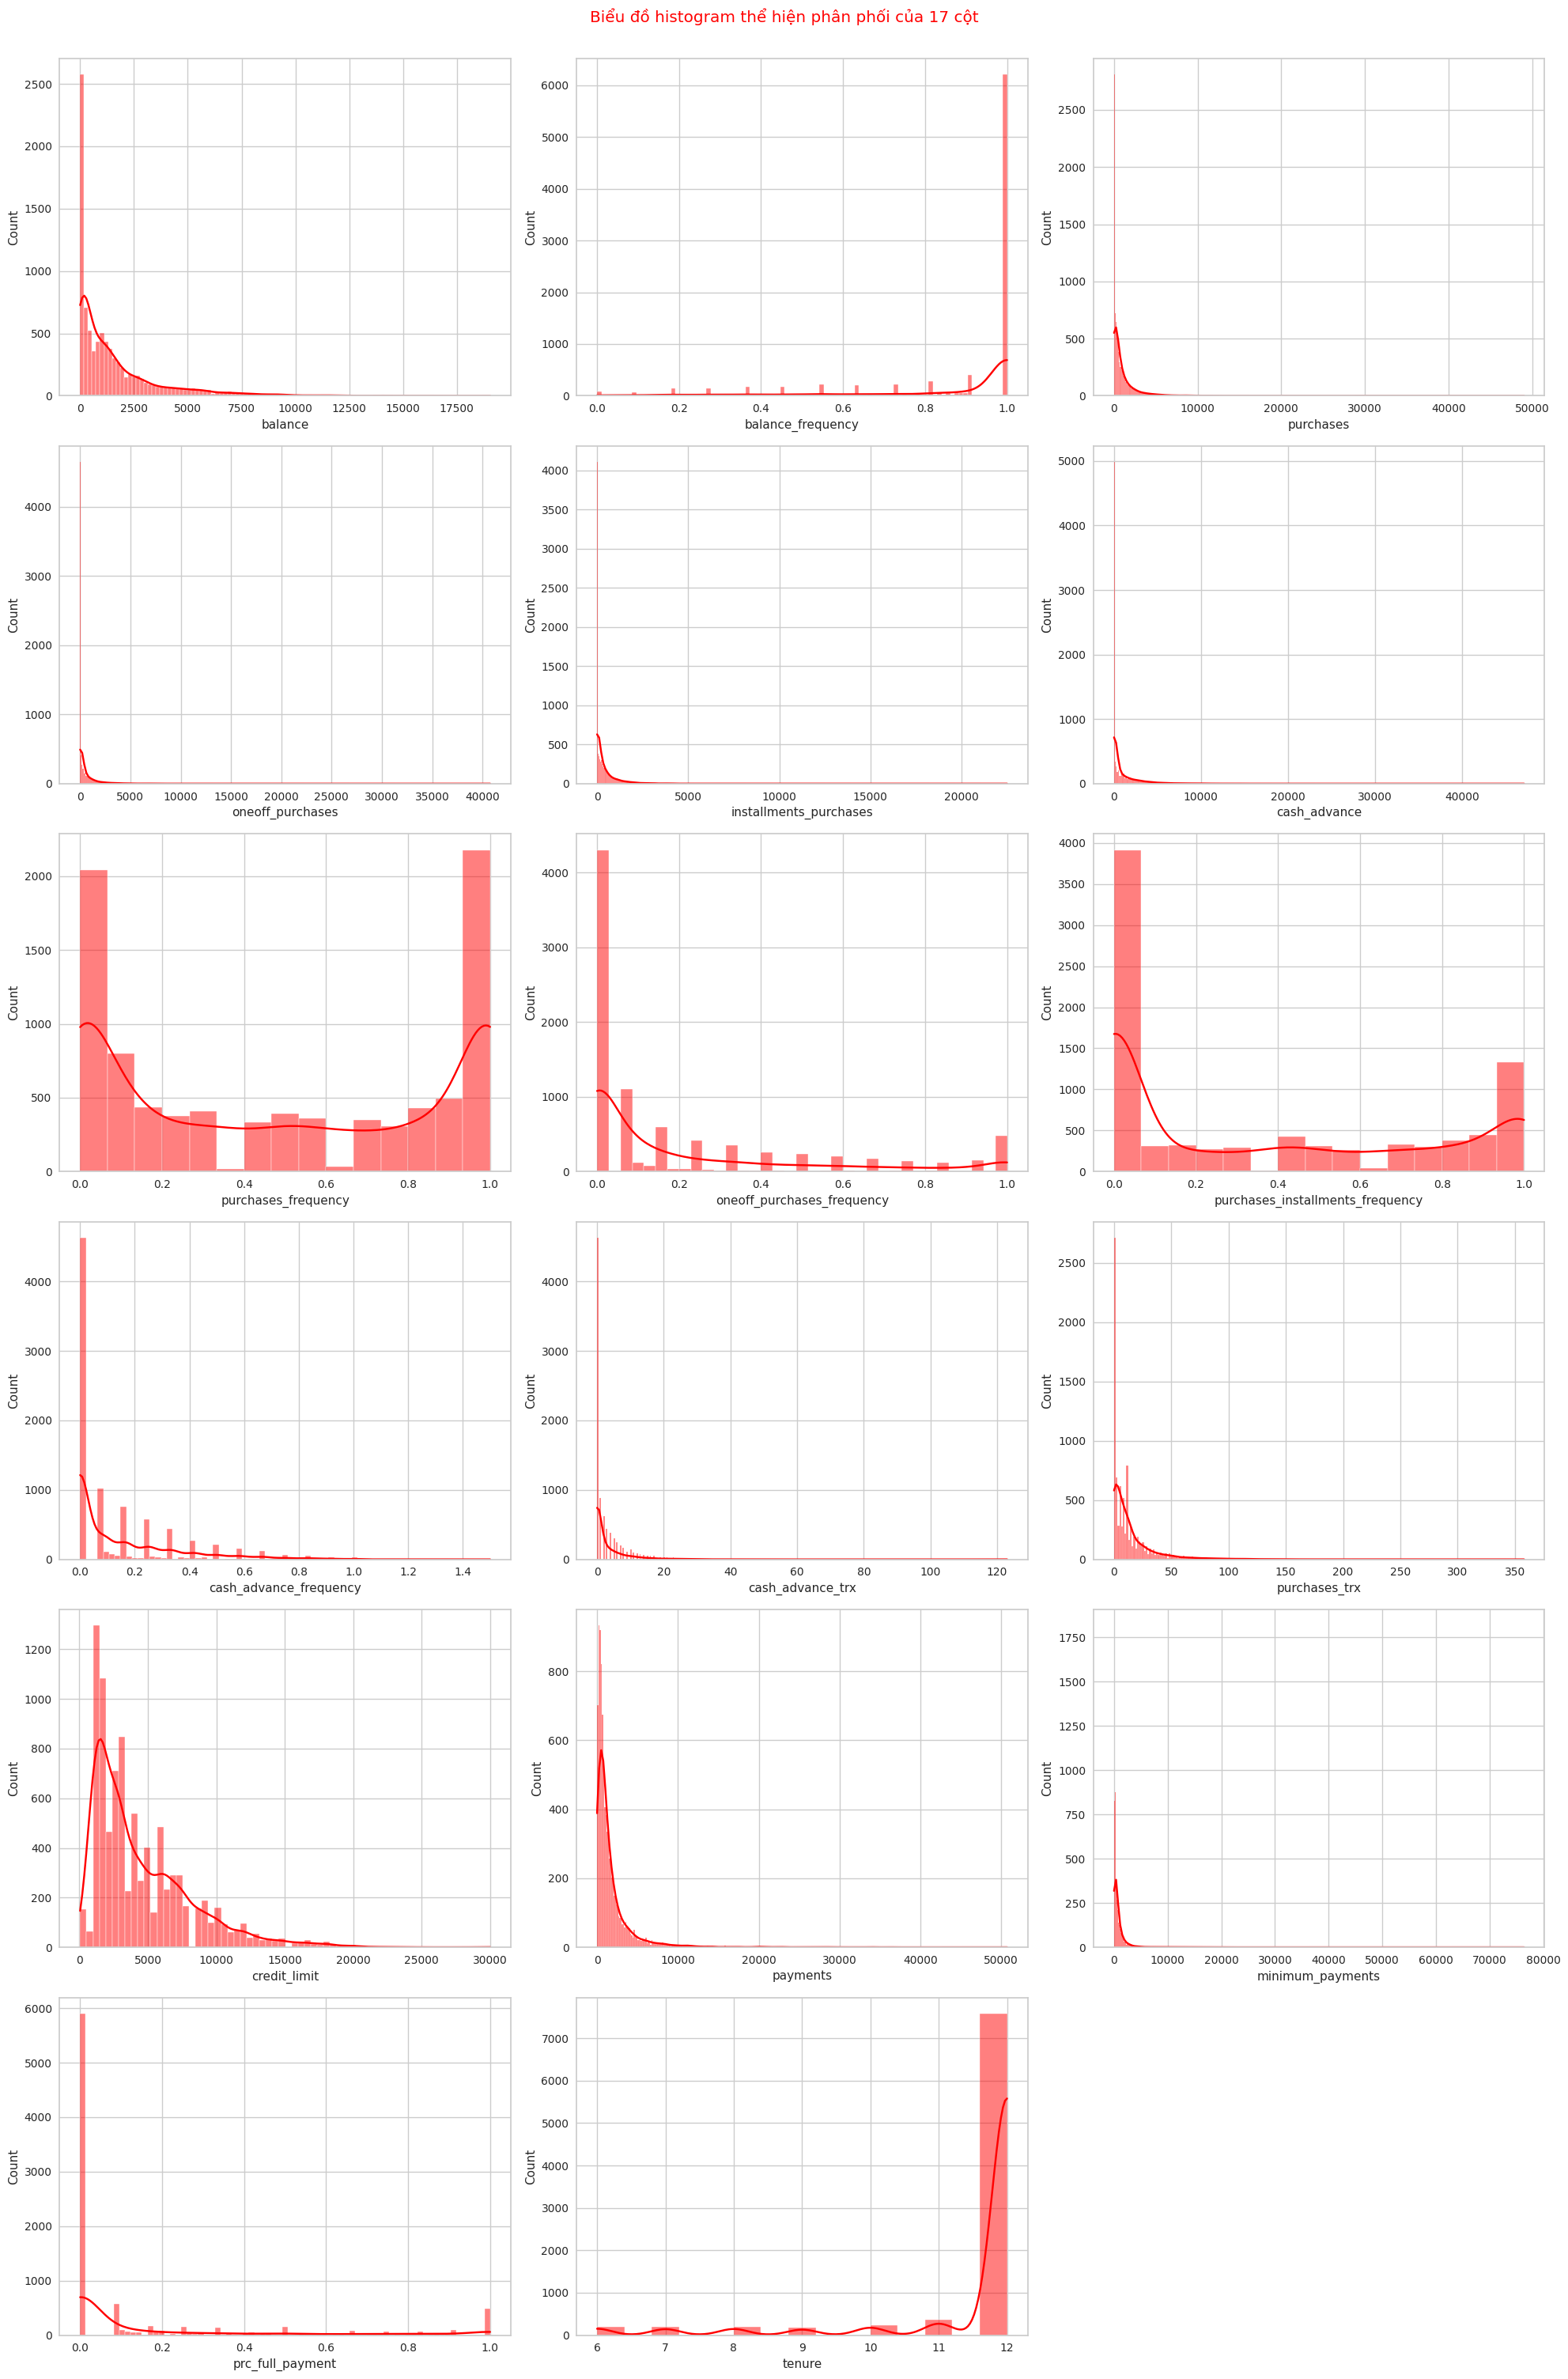

In [ ]:
fig, ax = plt.subplots(6, 3, figsize=(20, 6*5))
ax = ax.flatten()  # chuyển object ax từ mảng 2D sang mảng 1D

for i, col in enumerate(df):
    sns.histplot(df[col], kde=True, ax=ax[i], color='red')

# xóa subplot thừa
for i in range(len(df.columns), len(ax)):
    fig.delaxes(ax[i])

fig.suptitle('Biểu đồ histogram thể hiện phân phối của 17 cột', y=1.002, color="red")
fig.tight_layout()
plt.show()

> Dựa theo biểu đồ histogram, nhiều cột lệch phải nặng.
>
> Xem xét biểu đồ cho biến ***tenure***: Khi sử dụng thẻ tín dụng, hầu hết khách hàng sử dụng thẻ tín dụng đều thích thời hạn sử dụng thẻ 12 tháng so với các lựa chọn thời hạn sử dụng khác. Điều này có thể kết luận rằng khách hàng có nhiều khả năng trả nợ tín dụng trong thời gian dài hơn bất chấp lãi suất cao hơn. [1]
>
> Phân bố tần suất mua hàng (***purchases_frequency***) có hai đỉnh, một ở số không (phía bên trái của biểu đồ) và một ở số một (phía bên phải của biểu đồ). Do đó, dựa trên đặc trưng này, dữ liệu có thể được chia thành hai cụm [2]:
>
> - Khách hàng có tần suất mua hàng thấp (low purchases_frequency)
>
> - Khách hàng có tần suất mua hàng cao (high purchases_frequency)
>
> Phân bố tần suất trả góp mua hàng (***purchases_installments_frequency***) cũng có hai đỉnh, một ở số không (phía bên trái của biểu đồ) và một ở số một (phía bên phải của biểu đồ). Do đó, dựa trên đặc trưng này, dữ liệu có thể được chia thành hai cụm [2]:
>
> - Khách hàng có tần suất trả góp mua hàng thấp (low purchases_installments_frequency)
>
> - Khách hàng có tần suất trả góp mua hàng cao (high purchases_installments_frequency)

> **Vẽ biểu đồ hộp để kiểm tra các giá trị ngoại lai**
>
> Chọn phương pháp IQR (Interquartile Range) để kiểm tra outliers vì:
- Ít bị ảnh hưởng bởi phân phối lệch hoặc giá trị cực đoan (vì nó dựa trên percentiles, không phụ thuộc vào trung bình)
- Hoạt động tốt với dữ liệu lệch phải hoặc lệch trái
>
> Phương pháp IQR:
- Tính Q1 (tứ phân vị 25%) và Q3 (tứ phân vị 75%) cho từng cột số (numerical_cols).
- Tính IQR = Q3 - Q1 (khoảng cách giữa Q1 và Q3).
- Xác định ngưỡng dưới và ngưỡng trên:
Ngưỡng dưới = Q1 - 1.5 * IQR.
Ngưỡng trên = Q3 + 1.5 * IQR.
- Các giá trị nằm ngoài khoảng [Ngưỡng dưới, Ngưỡng trên] được xem là outliers.

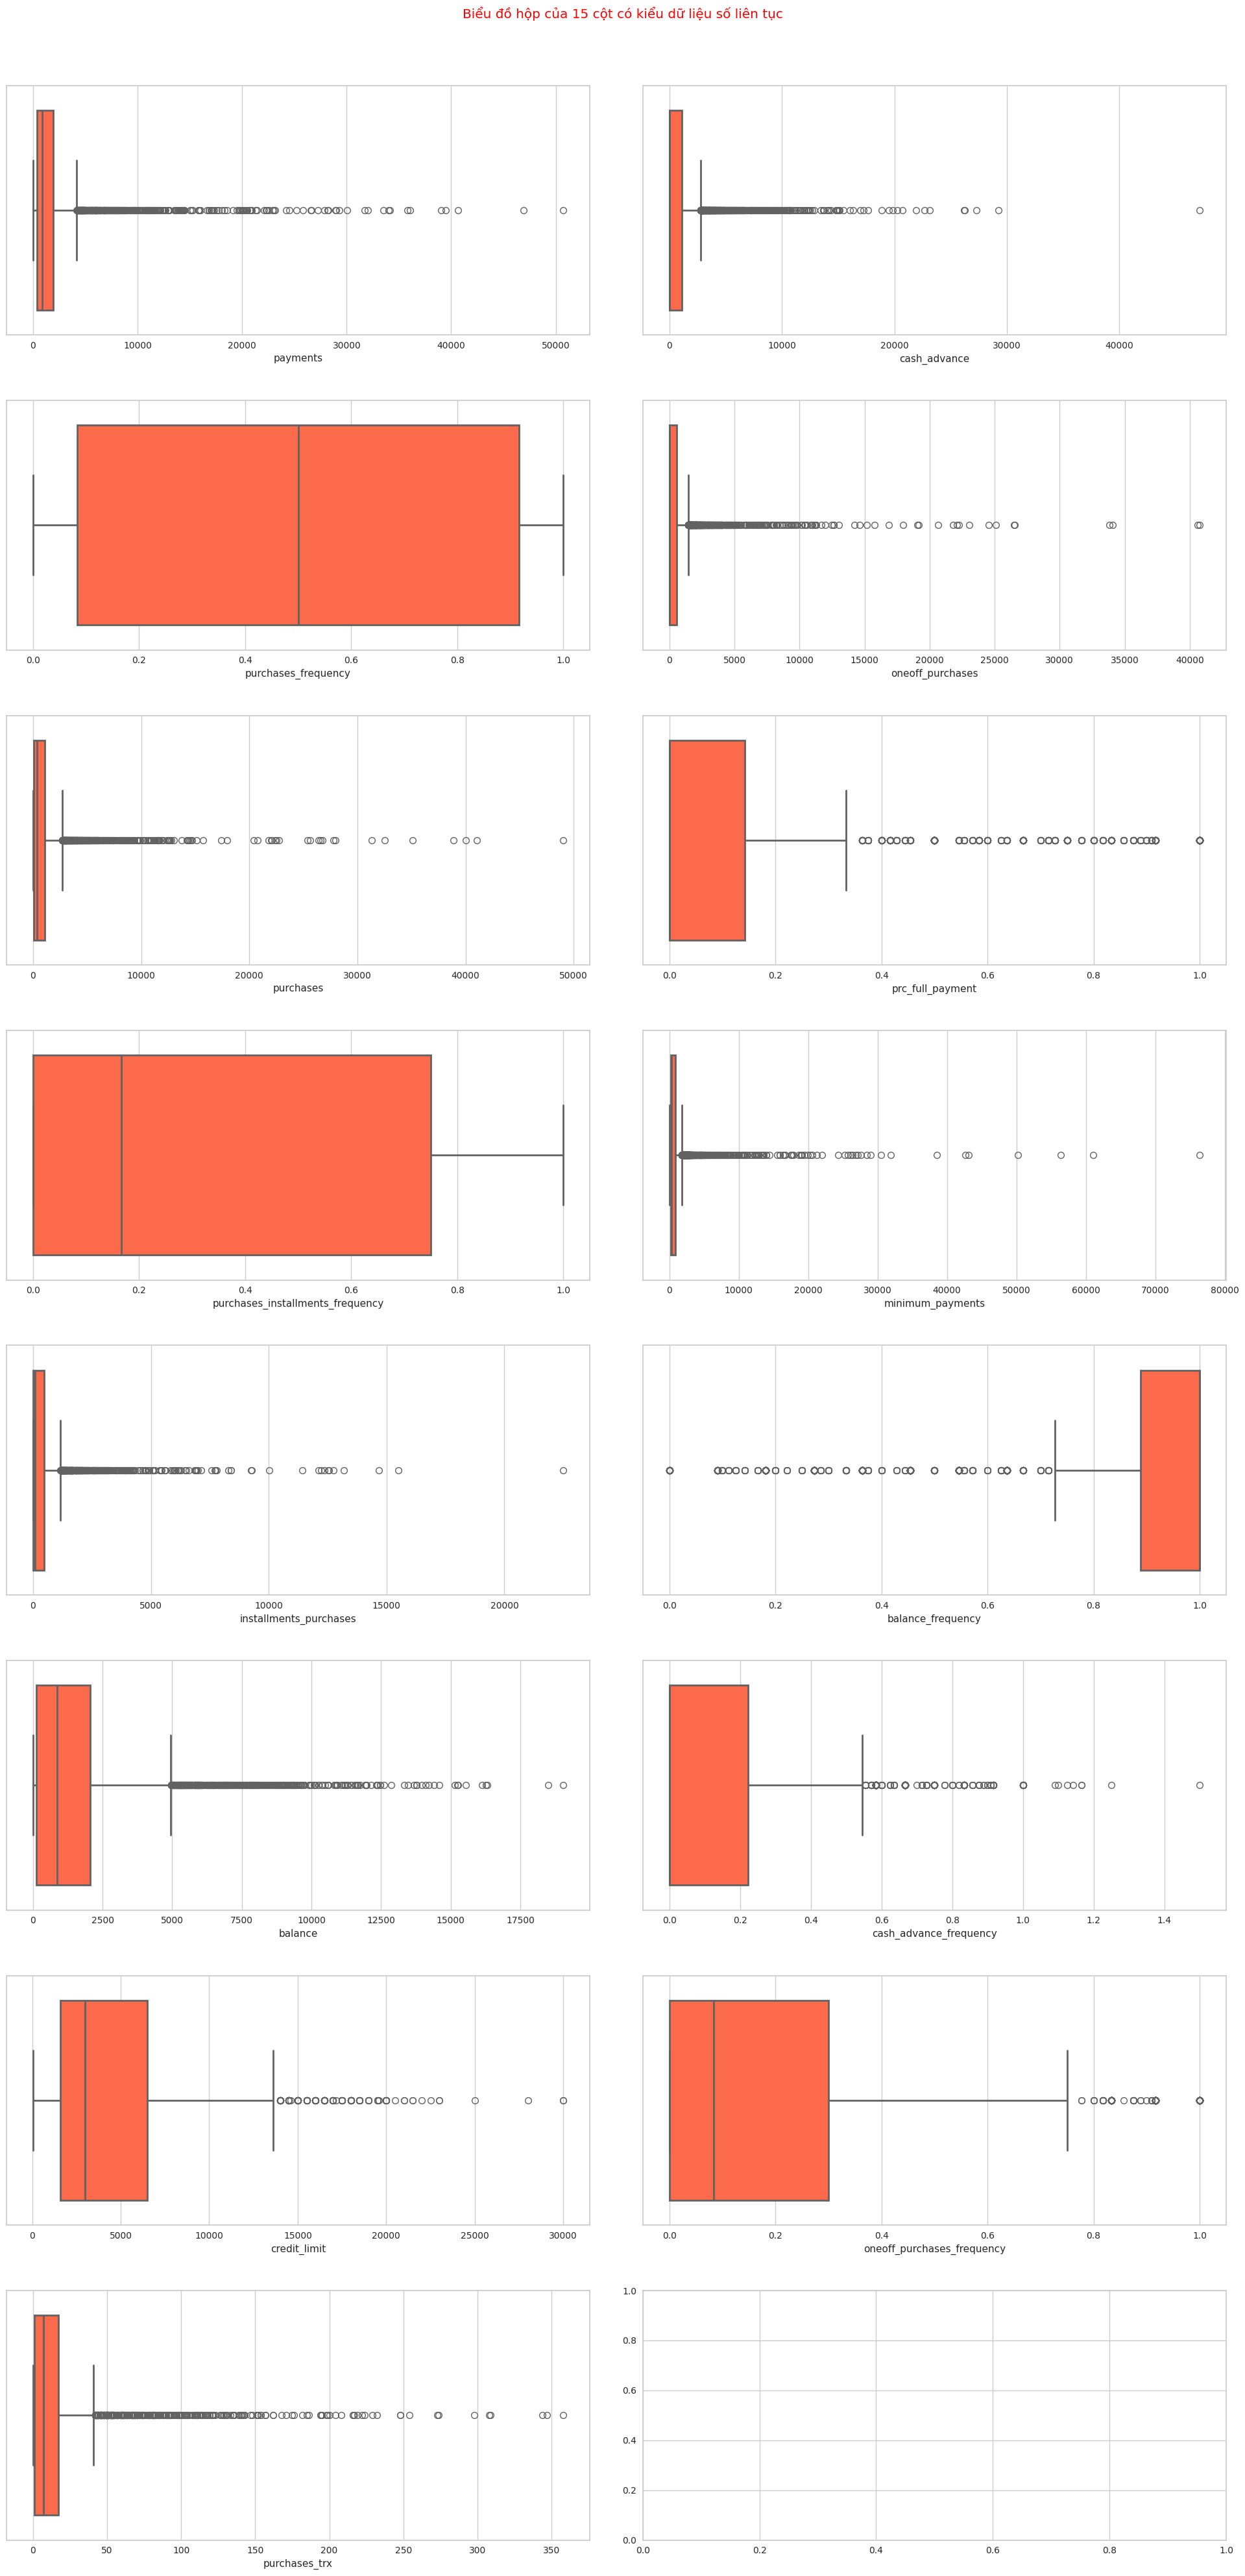

In [ ]:
fig, ax = plt.subplots(8,2,figsize=(20,40))
for i, col in enumerate(set(df.columns)-set(['tenure', 'cash_advance_trx'])): # không tính tenure, cash_advance_trx vì đây là biến số rời rạc
    sns.boxplot(data=df, x=col, palette="Reds_r", saturation=1, linewidth = 2, ax=ax[i//2, i%2])
# xóa subplot thừa
for i in range(len(set(df.columns) - set(['tenure', 'CASH_ADVANCE_TRX'])), len(ax)):
    fig.delaxes(ax[i])

plt.suptitle("Biểu đồ hộp của 15 cột có kiểu dữ liệu số liên tục", y=1, color="red")
plt.tight_layout(pad=3.0)
plt.show()

> Nhận xét:
>
> Cột ***purchases_installments_frequency***, ***purchases_frequency*** không có outlier
>
> Trừ cột ***balance_frequency***, các cột còn lại đều có nhiều outliers ở phía bên phải (vì những cột này có phân phối lệch phải)
>
> Vì vậy, cần áp dụng phương pháp xử lý outliers. Bởi vì những outliers trên vẫn mang ý nghĩa thực tế, nên chóm chọn cách không loại bỏ hoặc thay thế giá trị của chúng. Thay vào đó, nhóm chọn phương pháp chuẩn hóa dữ liệu phù hợp để giảm thiểu tác động của outliers khi phân cụm.

## **4.2 Bivariate Analysis**
Phân tích 2 biến

In [ ]:
# pair plot
pplot = sns.pairplot(df, palette="Reds_r", markers='.', plot_kws={'color': 'red'}, diag_kws={'color': 'red'})
pplot.fig.suptitle("Pairplot of Features", y=1.02)
pplot.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## **4.3 Multivariate Analysis**
Phân tích nhiều biến

> Vì tất cả các cột đều có kiểu dữ liệu số, dùng hệ số tương quan Pearson và ma trận tương quan để phân tích

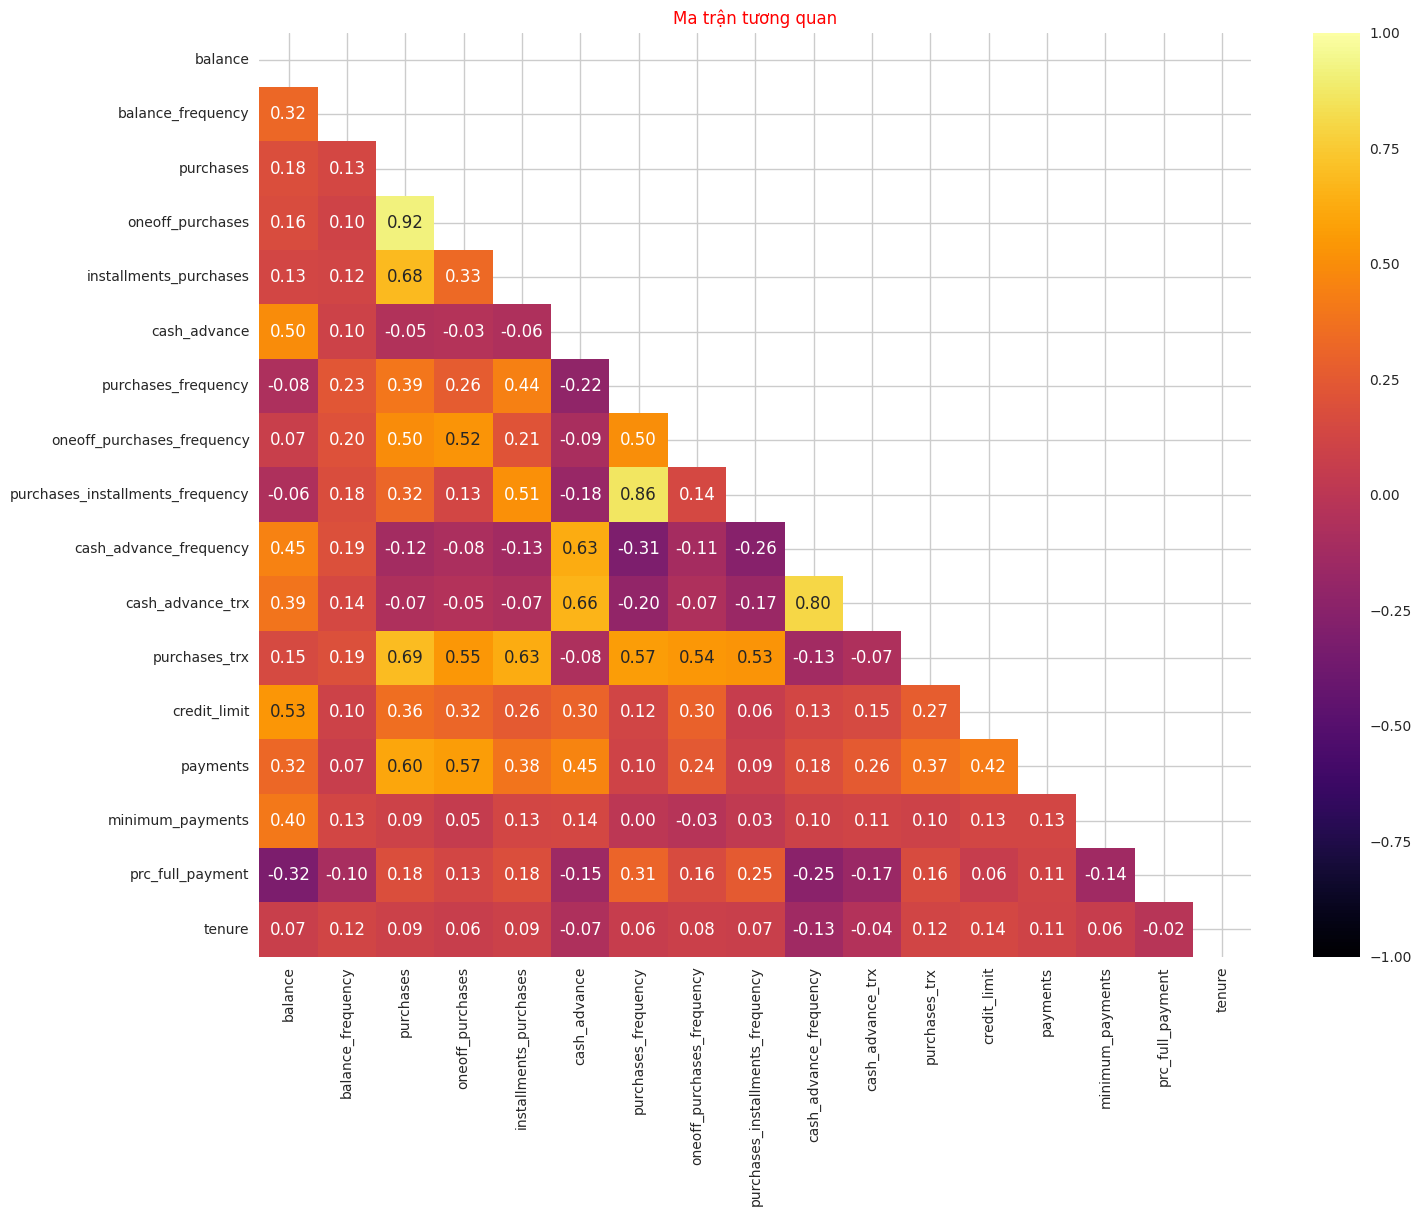

In [ ]:
corr_matrix = df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="inferno", vmin=-1, vmax=1)
plt.title("Ma trận tương quan", color="red")
plt.show()

> Một số biến có độ tương quan từ trung bình đến cao với các biến khác (từ 0.5 đến 1).

> Masking: Ẩn các mối quan hệ yếu (giá trị tương quan nhỏ hơn 0.5) để tập trung vào các mối quan hệ quan trọng

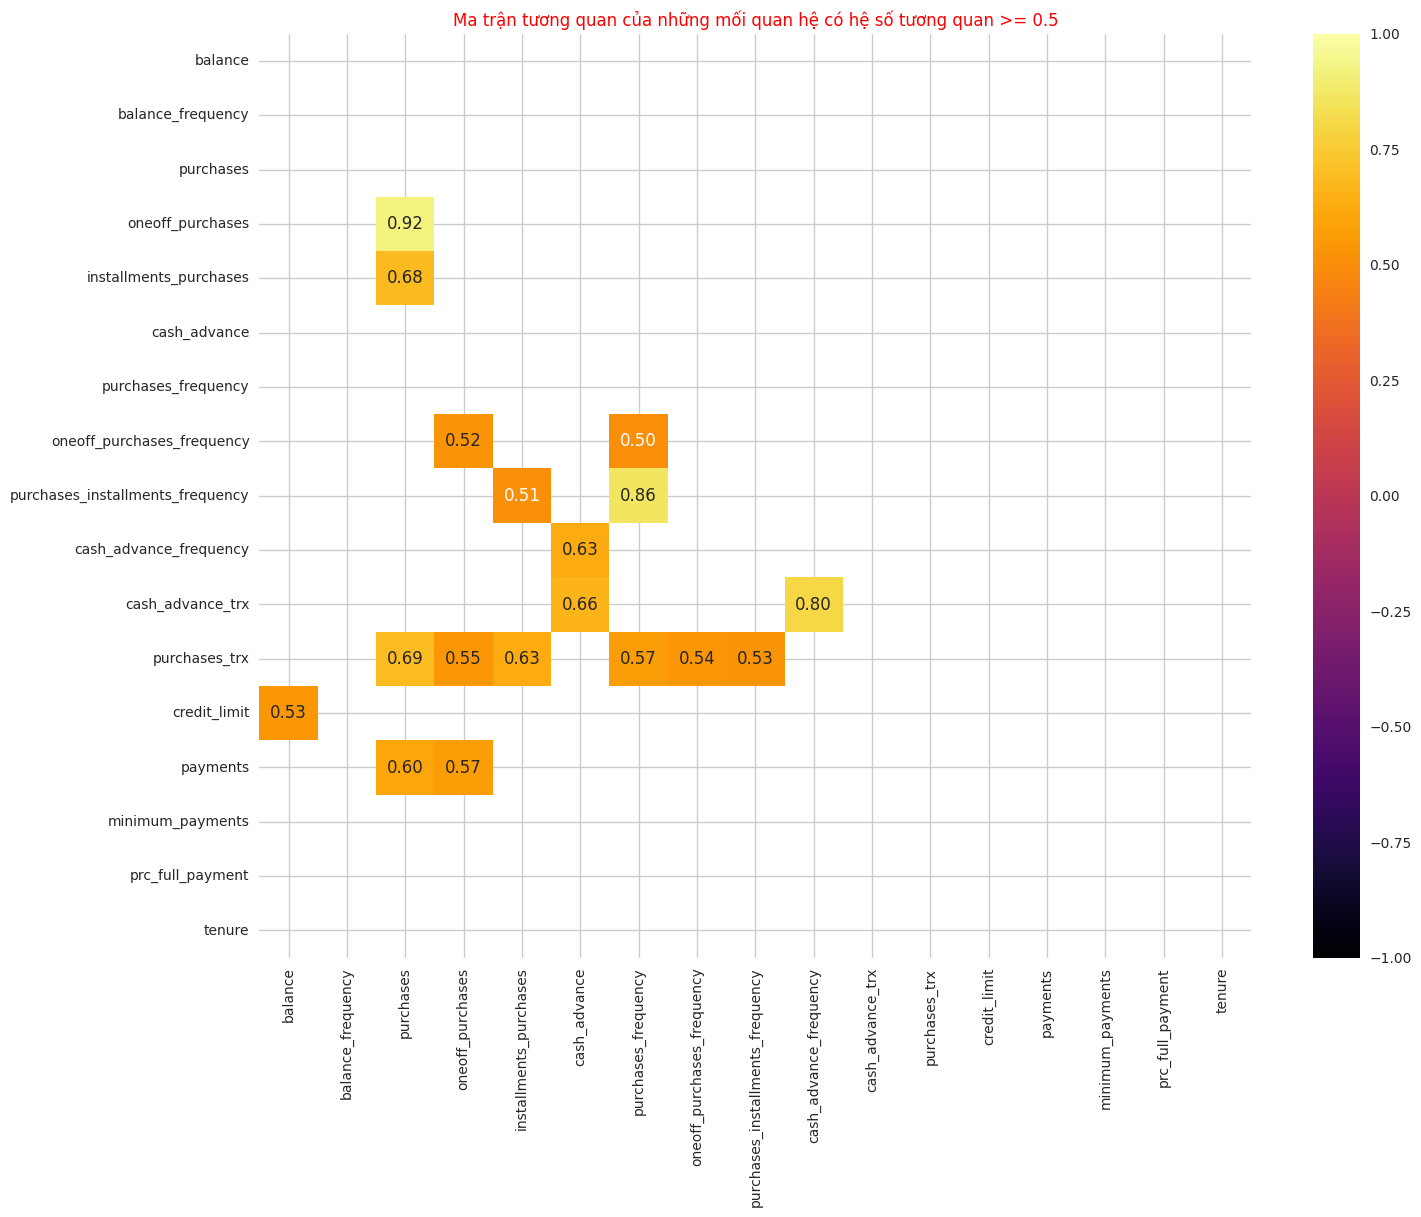

In [ ]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) | (np.abs(corr_matrix) < 0.5)

filtered_corr = corr_matrix.mask(mask)

plt.figure(figsize=(16, 12))
sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap="inferno", vmin=-1, vmax=1)
plt.title("Ma trận tương quan của những mối quan hệ có hệ số tương quan >= 0.5", color="red")
plt.show()

# **5. Xử lý giá trị bị thiếu**


> Vì tập dữ liệu liên quan đến việc phân cụm, phương pháp điền dữ liệu thiếu sẽ sử dụng KNNImputer() để tránh kết quả phân cụm bị sai lệch [1]. Giá trị trung bình từ n_neighbors gần nhất được tìm thấy trong tập dữ liệu sẽ được sử dụng để điền vào các giá trị bị thiếu cho mỗi mẫu.
>
> KNNImputer sử dụng giá trị của các mẫu "hàng xóm gần nhất" (k-nearest neighbors) để dự đoán giá trị thiếu, dựa trên khoảng cách (thường là khoảng cách Euclid) giữa các mẫu trong không gian đặc trưng. Trong bài toán phân cụm, các đặc trưng có mối quan hệ quan trọng để xác định cụm. KNNImputer khai thác mối quan hệ này, giúp điền dữ liệu thiếu theo cách duy trì cấu trúc tự nhiên của dữ liệu.
>
> Nhược điểm của một số phương pháp khác như:
> - Điền giá trị trung bình hoặc trung vị của cột: Không quan tâm đến mối quan hệ giữa các mẫu, dễ làm mất cấu trúc phân cụm.
> - Điền bằng một giá trị cố định: Có thể tạo ra các "cụm giả" không có ý nghĩa.


In [ ]:
imputer = KNNImputer()

imputer.fit(df)
df1 = pd.DataFrame(imputer.transform(df),columns=df.columns)

print(f'Số giá trị bị thiếu (trước): {df.isna().sum().sum()}')
print(f'Số giá trị bị thiếu (sau): {df1.isna().sum().sum()}')

Số giá trị bị thiếu (trước): 314
Số giá trị bị thiếu (sau): 0


# **6. Áp dụng mô hình phân cụm**

## **6.1 BIRCH**


### **6.1.1 Phân cụm giai đoạn 1**

In [ ]:
from scipy.stats import boxcox
from sklearn.preprocessing import RobustScaler
data = df1.copy()

columns_to_scale = ['balance', 'purchases',
 'oneoff_purchases','installments_purchases',
 'cash_advance','cash_advance_trx', 'credit_limit', 'payments',
 'minimum_payments', 'tenure']

# Lựa chọn phương pháp chuẩn hóa:
# 1. Quantile Transformer
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
data_quantile = data.copy()
data_quantile[columns_to_scale] = quantile_transformer.fit_transform(data[columns_to_scale])

# 2. Box-Cox Transformation
# Box-Cox yêu cầu dữ liệu không âm -> Dữ liệu = 0 => Thêm hằng số nhỏ
data_boxcox = data.copy()
for column in columns_to_scale:
    data_boxcox[column] = boxcox(data_boxcox[column] + 1e-6, lmbda=None)[0]

# 3. Robust Scaler
robust_scaler = RobustScaler()
data_robust = data.copy()
data_robust[columns_to_scale] = robust_scaler.fit_transform(data[columns_to_scale])

# 4. Standard Scaler
standard_scaler = StandardScaler()
data_standard = data.copy()
data_standard[columns_to_scale] = standard_scaler.fit_transform(data[columns_to_scale])

# Áp dụng BIRCH với dữ liệu đã chuẩn hóa
birch_model = Birch(n_clusters=None)
labels_quantile = birch_model.fit_predict(data_quantile)
labels_boxcox = birch_model.fit_predict(data_boxcox)
labels_robust = birch_model.fit_predict(data_robust)
labels_standard = birch_model.fit_predict(data_standard)

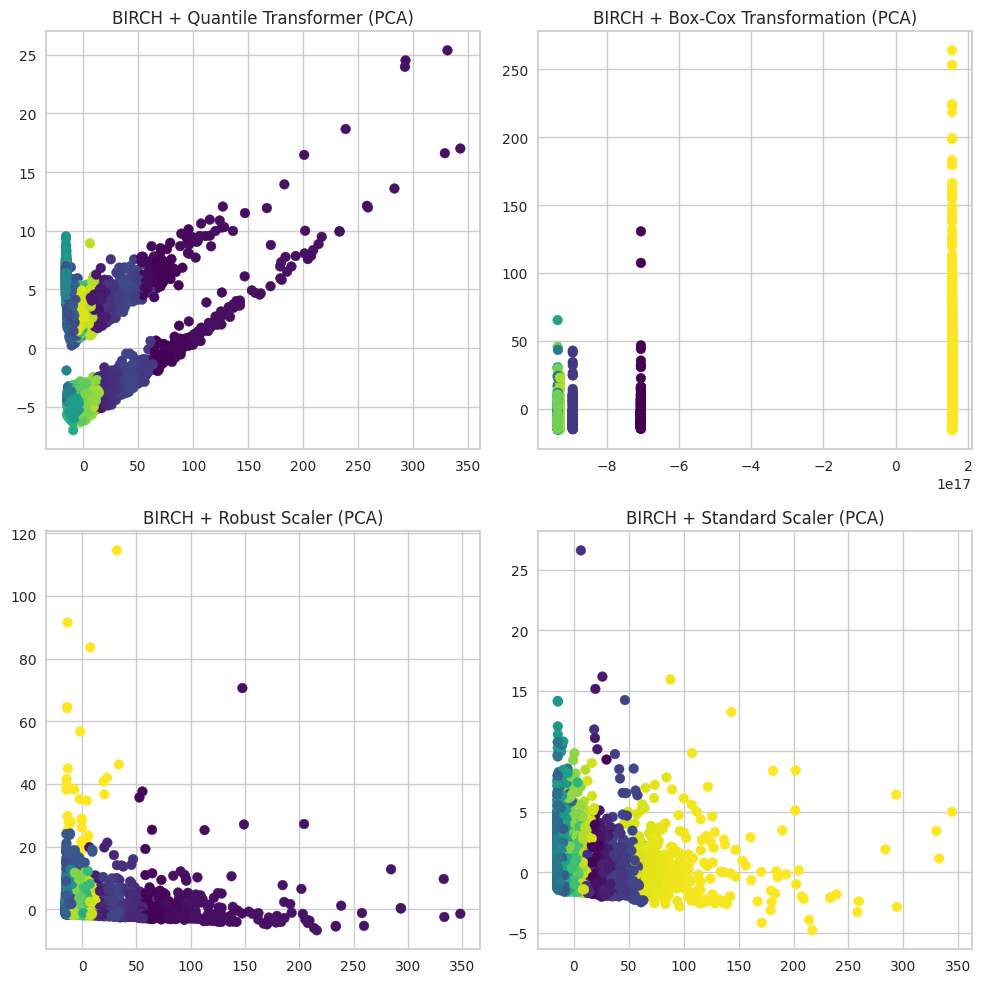

In [ ]:
# Áp dụng PCA để giảm chiều dữ liệu xuống 2D để biểu diễn
pca = PCA(n_components=2)

data_quantile_pca = pca.fit_transform(data_quantile)
data_boxcox_pca = pca.fit_transform(data_boxcox)
data_robust_pca = pca.fit_transform(data_robust)
data_standard_pca = pca.fit_transform(data_standard)

# Vẽ scatter plot sau khi giảm chiều
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

axes[0].scatter(data_quantile_pca[:, 0], data_quantile_pca[:, 1], c=labels_quantile, cmap='viridis')
axes[0].set_title("BIRCH + Quantile Transformer (PCA)")

axes[1].scatter(data_boxcox_pca[:, 0], data_boxcox_pca[:, 1], c=labels_boxcox, cmap='viridis')
axes[1].set_title("BIRCH + Box-Cox Transformation (PCA)")

axes[2].scatter(data_robust_pca[:, 0], data_robust_pca[:, 1], c=labels_robust, cmap='viridis')
axes[2].set_title("BIRCH + Robust Scaler (PCA)")

axes[3].scatter(data_standard_pca[:, 0], data_standard_pca[:, 1], c=labels_standard, cmap='viridis')
axes[3].set_title("BIRCH + Standard Scaler (PCA)")

plt.tight_layout()
plt.show()

In [ ]:
df_boxcox = pd.DataFrame(data_boxcox, columns=df1.columns)
df_quantile = pd.DataFrame(data_quantile, columns=df1.columns)
df_robust = pd.DataFrame(data_robust, columns=df1.columns)
df_standard = pd.DataFrame(data_standard, columns=df1.columns)

In [ ]:
df_c = df_boxcox.copy()
df_c['cluster'] = labels_boxcox
cluster_counts = df_c['cluster'].value_counts().sort_index()
cluster_counts.reset_index(drop=True, inplace=True)
cluster_counts

,count
0,365
1,236
2,196
3,190
4,204
5,175
6,7584


> Box-cox cho ra 7 cụm ngay trong giai đoạn 1

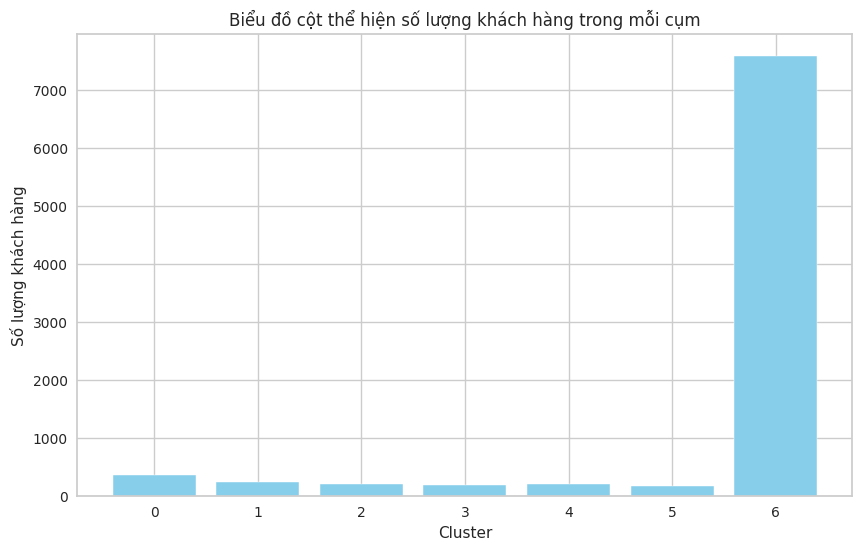

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel("Cluster")
plt.ylabel("Số lượng khách hàng")
plt.title("Biểu đồ cột thể hiện số lượng khách hàng trong mỗi cụm")
plt.xticks(cluster_counts.index)
plt.show()

In [ ]:
df_c = df_quantile.copy()
df_c['cluster'] = labels_quantile
df_c['cluster'].value_counts()

,count
cluster,
2862,48
2984,36
2880,34
2970,33
2882,25
...,...
1054,1
5032,1
303,1


In [ ]:
df_c = df_robust.copy()
df_c['cluster'] = labels_robust
df_c['cluster'].value_counts()

,count
cluster,
1983,80
1938,61
1984,52
4248,46
1926,41
...,...
4850,1
669,1
465,1


In [ ]:
df_c = df_standard.copy()
df_c['cluster'] = labels_robust
df_c['cluster'].value_counts()

,count
cluster,
1983,80
1938,61
1984,52
4248,46
1926,41
...,...
4850,1
669,1
465,1


> Các phương pháp chuẩn hóa dữ liệu còn lại cho ra số cụm rất lớn

In [ ]:
# Tính Silhouette Score cho từng phương pháp
silhouette_quantile = silhouette_score(data_quantile, labels_quantile)
silhouette_boxcox = silhouette_score(data_boxcox, labels_boxcox)
silhouette_robust = silhouette_score(data_robust, labels_robust)

print("Silhouette Score (Quantile Transformer):", silhouette_quantile)
print("Silhouette Score (Box-Cox Transformation):", silhouette_boxcox)
print("Silhouette Score (Robust Scaler):", silhouette_robust)

Silhouette Score (Quantile Transformer): 0.08066841239812216
Silhouette Score (Box-Cox Transformation): 1.0
Silhouette Score (Robust Scaler): 0.0840212658029144


> Từ kết quả phân cụm, có thể thấy dùng phương pháp box-cox có thể cho ra các cụm tốt ngay từ giai đoạn 1. Tuy nhiên phương pháp này làm mất nhiều thông tin ban đầu của dữ liệu.
>
> Với các phương pháp quantile, robust và standard, cần điều chỉnh tham số T, B hoặc thực hiện phân cụm toàn cục để cho ra số cụm hợp lý.

In [ ]:
thresholds = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
branching_factors = [20, 30, 40, 50, 60]

best_score = -1
best_params = {}
best_labels = None

for threshold in thresholds:
    for branching_factor in branching_factors:
        birch_model = Birch(threshold=threshold, branching_factor=branching_factor, n_clusters=None)

        labels = birch_model.fit_predict(data_quantile)

        score = silhouette_score(data_quantile, labels)

        print(f"Threshold: {threshold}, Branching Factor: {branching_factor}, Silhouette Score: {score}")

        if score > best_score:
            best_score = score
            best_params = {'threshold': threshold, 'branching_factor': branching_factor}
            best_labels = labels

print(f"\nBest parameters: {best_params}, Best Silhouette Score: {best_score}")

Threshold: 0.5, Branching Factor: 20, Silhouette Score: 0.07229324292705008
Threshold: 0.5, Branching Factor: 30, Silhouette Score: 0.07732689841727058
Threshold: 0.5, Branching Factor: 40, Silhouette Score: 0.08420578047794121
Threshold: 0.5, Branching Factor: 50, Silhouette Score: 0.08066841239812216
Threshold: 0.5, Branching Factor: 60, Silhouette Score: 0.08816549301201555
Threshold: 1.0, Branching Factor: 20, Silhouette Score: 0.10237598757674576
Threshold: 1.0, Branching Factor: 30, Silhouette Score: 0.11770966690550486
Threshold: 1.0, Branching Factor: 40, Silhouette Score: 0.11911473590795528
Threshold: 1.0, Branching Factor: 50, Silhouette Score: 0.11944838566968241
Threshold: 1.0, Branching Factor: 60, Silhouette Score: 0.1172025601213498
Threshold: 1.5, Branching Factor: 20, Silhouette Score: 0.13277490561173866
Threshold: 1.5, Branching Factor: 30, Silhouette Score: 0.1427345623106577
Threshold: 1.5, Branching Factor: 40, Silhouette Score: 0.1363492780797193
Threshold: 1.5,

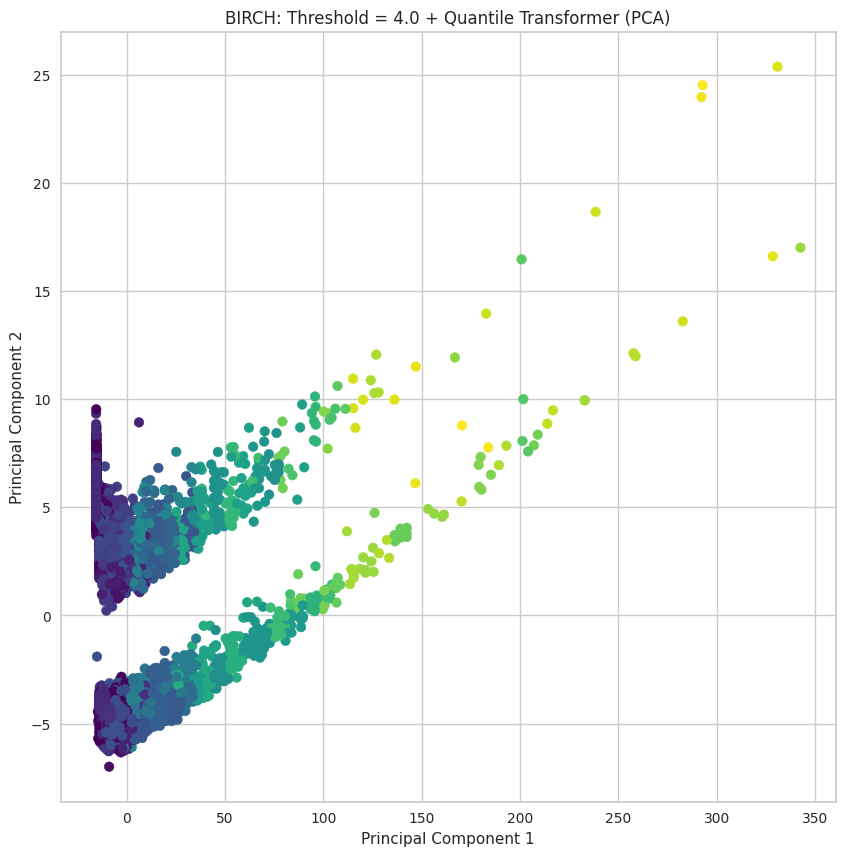

In [ ]:
# Giảm chiều xuống còn 2 để biểu diễn trực quan
pca = PCA(n_components=2)
data_quantile_pca = pca.fit_transform(data_quantile)


plt.figure(figsize=(10, 10))
plt.scatter(data_quantile_pca[:, 0], data_quantile_pca[:, 1], c=best_labels, cmap='viridis')
plt.title("BIRCH: Threshold = 4.0 + Quantile Transformer (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.show()

In [ ]:
unique_labels = np.unique(best_labels)
print("Số cụm sau khi điều chỉnh threshold:", len(unique_labels))

Số cụm sau khi điều chỉnh threshold: 142


### **6.1.2 Phân cụm toàn cục bằng HAC**

In [ ]:
# 1. Khởi tạo mô hình BIRCH
birch = Birch(n_clusters=None)

In [ ]:
# 2. Tạo grid các tham số để tìm kiếm
param_grid = {
    'threshold': [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0],
    'branching_factor': [20, 30, 40, 50, 60],
    'n_clusters': [2, 3, 4, 5, 6, 7, 8] # Phân cụm toàn cục bằng Agglomerative Hierarchical Clustering với n_cluster=số cụm
}

In [ ]:
# 3. Hàm đánh giá Silhouette Score
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) > 1:  # Chỉ tính Silhouette Score nếu có ít nhất 2 cụm
        return silhouette_score(X, labels)
    return np.nan

In [ ]:
# 4. GridSearchCV để tối ưu tham số cho dữ liệu gốc
print(f"Running GridSearchCV with Silhouette Scorer...")
grid_search = GridSearchCV(birch, param_grid, scoring=silhouette_scorer, error_score=np.nan, cv=3)
grid_search.fit(df_quantile)

Running GridSearchCV with Silhouette Scorer...


GridSearchCV(cv=3, estimator=Birch(n_clusters=None),
             param_grid={'branching_factor': [20, 30, 40, 50, 60],
                         'n_clusters': [2, 3, 4, 5, 6, 7, 8],
                         'threshold': [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]},
             scoring=<function silhouette_scorer at 0x7835a1feb910>)

In [ ]:
# 5. Hiển thị kết quả tối ưu hóa siêu tham số
print("Kết quả tối ưu hóa siêu tham số - BIRCH:")
print("Best Parameters:", grid_search.best_params_)
print(f"Best Silhouette Score: {grid_search.best_score_:.3f}")

Kết quả tối ưu hóa siêu tham số - BIRCH:
Best Parameters: {'branching_factor': 20, 'n_clusters': 2, 'threshold': 3.0}
Best Silhouette Score: 0.868


In [ ]:
silhouette = []
calinski_harabasz = []
davies_bouldin = []
for k in range(2,11):
    BR = Birch (n_clusters = k, branching_factor=20, threshold=3.0) # Giữ cài đặt đã chọn, chỉ tối ưu hóa số cụm
    BR.fit (data_quantile)

    score = silhouette_score (data_quantile , BR.predict(data_quantile))
    silhouette.append (score)

    score1 = calinski_harabasz_score (data_quantile, BR.predict(data_quantile))
    calinski_harabasz.append(score1)

    score2 = davies_bouldin_score (data_quantile, BR.predict(data_quantile))
    davies_bouldin.append (score2)

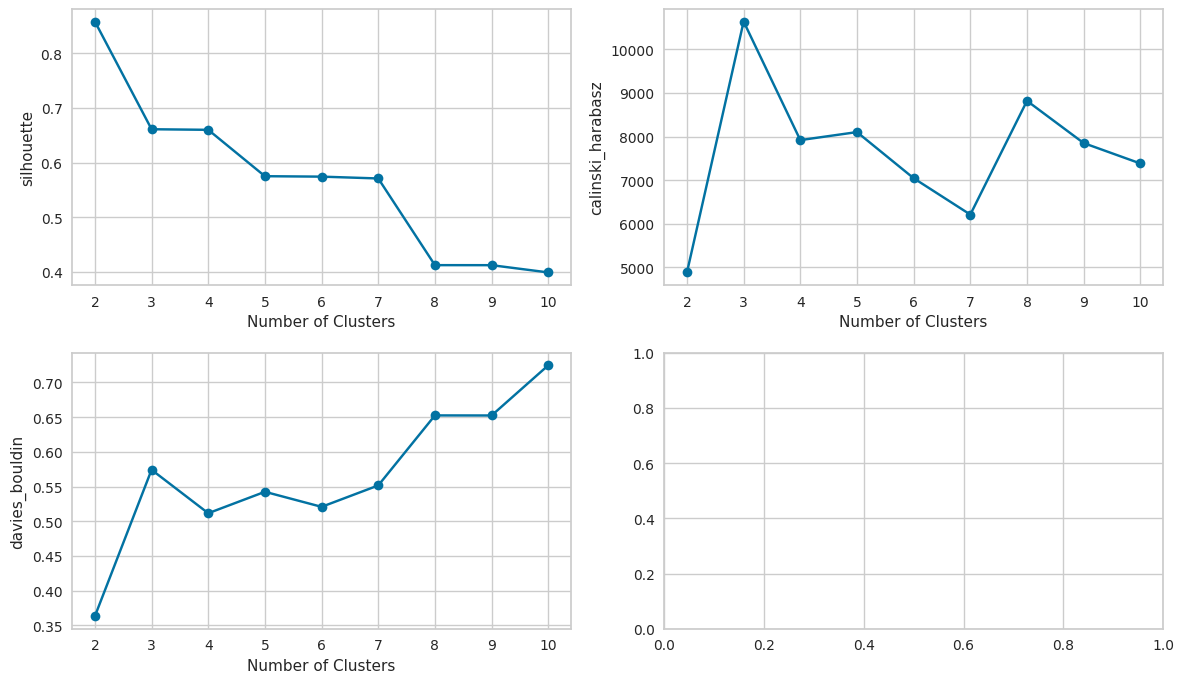

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

metrics = {'silhouette': silhouette, 'calinski_harabasz': calinski_harabasz,
           'davies_bouldin': davies_bouldin}
metrics_list = list(metrics.items())

for i in range(2):
    for j in range(2):
        index = i*2 + j
        if index < len(metrics_list):
            metric_name, metric_values = metrics_list[i*2 + j]
            axs[i, j].plot(range(2, 11), metric_values , marker = 'o')
            axs[i, j].set_xticks(range(2, 11))
            axs[i, j].set_xlabel('Number of Clusters')
            axs[i, j].set_ylabel(metric_name)
            axs[i, j].grid(True)

plt.tight_layout()
plt.show()

> Điểm tốt nhất của chỉ số silhouette là cho số cụm bằng 2
>
> Điểm tốt nhất của chỉ số calinski_harabasz là cho số cụm bằng 3
>
> Điểm tốt nhất cho chỉ số Davies-Bouldin là cho số cụm bằng 2
>
> => Chọn số cụm bằng 2 hoặc 3

> Sau khi tiến hành kiểm thử, kết quả phân cụm cho thấy số cụm = 3 cho ra các cụm tốt hơn số cụm = 2

In [ ]:
# 6. Phân cụm với các tham số đã chọn
BR = Birch (n_clusters = 3, branching_factor=20, threshold=3.0)
start = time.time()
birch_labels = BR.fit_predict(df_quantile)
end = time.time()

# Số lượng cụm xác định được (dựa trên nhãn phân cụm)
num_clusters = len(set(birch_labels))
birch_time = end - start

In [ ]:
df_c = df_quantile.copy()
df_c['cluster'] = birch_labels
df_c['cluster'].value_counts()

,count
cluster,
2,7924
1,952
0,74


> **Biểu diễn kết quả phân cụm**

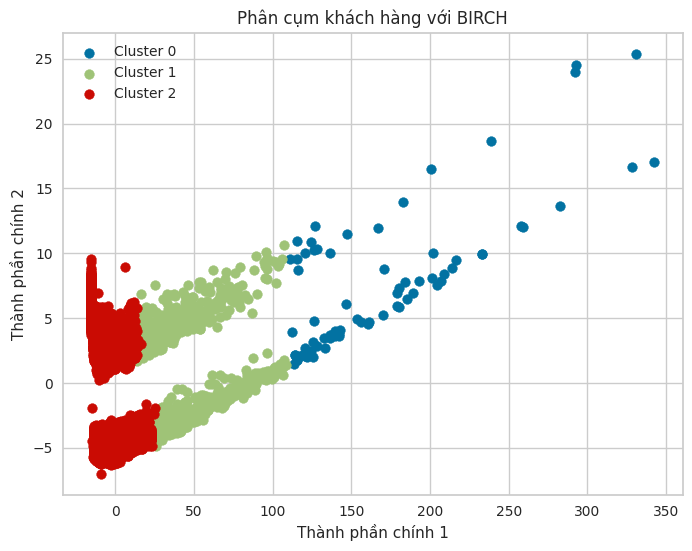

Cluster 0:
         balance  balance_frequency  purchases  oneoff_purchases  \
count  74.000000          74.000000  74.000000         74.000000   
mean    1.082976           0.998772   2.159222          1.575515   
std     1.040105           0.010568   0.634235          1.646595   
min    -0.648905           0.909091   0.531567         -5.199338   
25%     0.230499           1.000000   1.818937          1.312380   
50%     1.002300           1.000000   2.302592          1.885059   
75%     1.650962           1.000000   2.550772          2.439768   
max     5.199338           1.000000   3.381827          4.330616   

       installments_purchases  cash_advance  purchases_frequency  \
count               74.000000     74.000000            74.000000   
mean                 1.616685     -3.677440             0.977887   
std                  1.949432      2.724125             0.087837   
min                 -5.199338     -5.199338             0.363636   
25%                  1.511315     -5

In [ ]:
# 1. Biểu đồ phân tán (Scatter plot) với PCA:
#   - Sử dụng PCA để giảm số chiều dữ liệu xuống 2D hoặc 3D.
#   - Vẽ biểu đồ phân tán với các điểm dữ liệu được tô màu theo nhãn cụm.

pca = PCA(n_components=2)  # Giảm chiều xuống 2D
df_pca = pca.fit_transform(df_quantile)  # Áp dụng PCA cho dữ liệu đã được chuẩn hóa

plt.figure(figsize=(8, 6))
for cluster_label in set(birch_labels):
    cluster_data = df_pca[birch_labels == cluster_label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_label}')

plt.title('Phân cụm khách hàng với BIRCH')
plt.xlabel('Thành phần chính 1')
plt.ylabel('Thành phần chính 2')
plt.legend()
plt.show()

# 2. Phân tích profile cụm (Cluster profiling):
#    - Tính toán giá trị trung bình, trung vị, độ lệch chuẩn... của các thuộc tính trong mỗi cụm.
#    - So sánh các giá trị này giữa các cụm để hiểu đặc điểm của từng cụm.

for cluster_label in set(birch_labels):
    cluster_data = df_quantile[birch_labels == cluster_label]
    print(f"Cluster {cluster_label}:")
    print(cluster_data.describe())

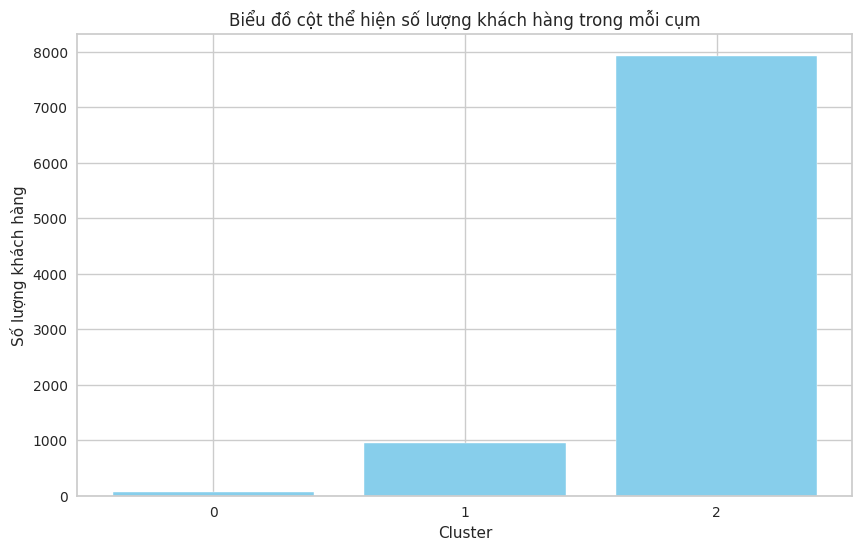

In [ ]:
cluster_counts = df_c['cluster'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel("Cluster")
plt.ylabel("Số lượng khách hàng")
plt.title("Biểu đồ cột thể hiện số lượng khách hàng trong mỗi cụm")
plt.xticks(cluster_counts.index)  # Ensure all cluster labels are shown
plt.show()

## **6.2 HAC**

In [ ]:
# 1. Khởi tạo mô hình HAC (Hierarchical Agglomerative Clustering)
hac = AgglomerativeClustering()

In [ ]:
# 2. Định nghĩa không gian tham số để tối ưu hóa
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # Số lượng cụm có thể thử
    'linkage': ['ward', 'complete', 'average', 'single']  # Các phương pháp liên kết
}

In [ ]:
# 3. Hàm đánh giá sử dụng Silhouette Score
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) > 1:  # Chỉ tính Silhouette Score nếu có ít nhất 2 cụm
        return silhouette_score(X, labels)
    return np.nan

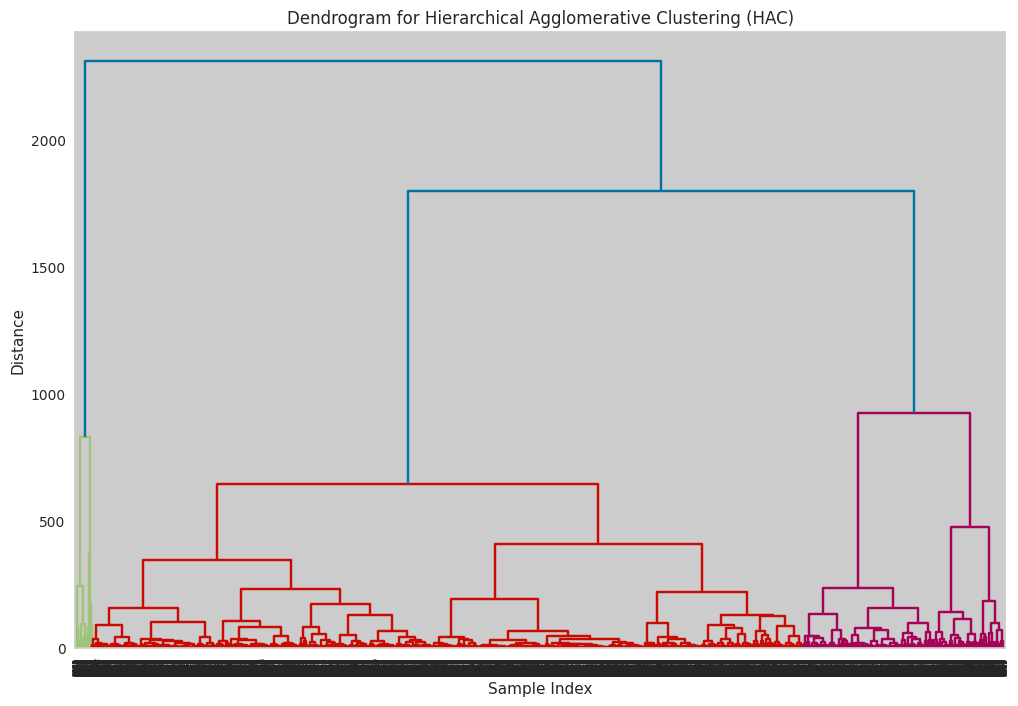

Running GridSearchCV with Silhouette Scorer...


GridSearchCV(cv=3, estimator=AgglomerativeClustering(), n_jobs=-1,
             param_grid={'linkage': ['ward', 'complete', 'average', 'single'],
                         'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring=<function silhouette_scorer at 0x783598e33640>)

In [ ]:
# 4. Phân cụm
# Vẽ Dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage(df_quantile, method='ward'))  # Sử dụng phương pháp 'ward' cho linkage
plt.title('Dendrogram for Hierarchical Agglomerative Clustering (HAC)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# GridSearchCV để tối ưu tham số
print(f"Running GridSearchCV with Silhouette Scorer...")
grid_search = GridSearchCV(estimator=hac, param_grid=param_grid, scoring=silhouette_scorer, cv=3, n_jobs=-1)
grid_search.fit(df_quantile)

In [ ]:
# Phân cụm với mô hình tốt nhất
best_hac = grid_search.best_estimator_
start = time.time()
labels = best_hac.fit_predict(df_quantile)
end = time.time()

# Số lượng cụm xác định được (dựa trên nhãn phân cụm)
num_clusters = len(set(labels))
hac_time = end - start

In [ ]:
# 6. Hiển thị kết quả tối ưu
print("Kết quả phân cụm bằng HAC:")
print(f"Số lượng cụm xác định được: {num_clusters}")
print("Best Parameters:", grid_search.best_params_)
print(f"Best Silhouette Score: {grid_search.best_score_:.3f}")

Kết quả phân cụm bằng HAC:
Số lượng cụm xác định được: 2
Best Parameters: {'linkage': 'single', 'n_clusters': 2}
Best Silhouette Score: 0.898


# **7. So sánh mô hình**

In [ ]:
print(f"BIRCH time: {birch_time:.4f} seconds")
print(f"HAC time: {hac_time:.4f} seconds")

birch_silhouette = silhouette_score(df_quantile, birch_labels)
hac_silhouette = silhouette_score(df_quantile, labels)

print(f"BIRCH Silhouette Score: {birch_silhouette:.4f}")
print(f"HAC Silhouette Score: {hac_silhouette:.4f}")

birch_calinski = calinski_harabasz_score(df_quantile, birch_labels)
hac_calinski = calinski_harabasz_score(df_quantile, labels)

print(f"BIRCH Calinski-Harabasz Index: {birch_calinski:.4f}")
print(f"HAC Calinski-Harabasz Index: {hac_calinski:.4f}")

birch_davies = davies_bouldin_score(df_quantile, birch_labels)
hac_davies = davies_bouldin_score(df_quantile, labels)

print(f"BIRCH Davies-Bouldin Index: {birch_davies:.4f}")
print(f"HAC Davies-Bouldin Index: {hac_davies:.4f}")

BIRCH time: 0.3069 seconds
HAC time: 1.1622 seconds
BIRCH Silhouette Score: 0.6610
HAC Silhouette Score: 0.9233
BIRCH Calinski-Harabasz Index: 10635.3422
HAC Calinski-Harabasz Index: 530.6180
BIRCH Davies-Bouldin Index: 0.5741
HAC Davies-Bouldin Index: 0.0760


# **Tài liệu tham khảo:**
>
> [1] https://www.kaggle.com/code/caesarmario/clustering-for-effective-marketing-strategy
>
> [2] https://www.kaggle.com/code/arezalo/credit-cart-customer-clustering